# CSCI-UA 0473 - Introduction to Machine Learning
## Wednesday, February 8, 2017

## Logistic Regression 

### Key Points
SETUP: We have a set of data points $\{(x_{1}, y_{1}), (x_{2}, y_{2}), ... , (x_{n}, y_{n})\}$, where $x_{i} \in R^{d}$ are the feature vectors and $y_{i} \in \{0, 1\}$ are the class labels.

MODEL: $p_{+} = p(y = 1|x) = \frac{1}{1 + e^{-w.x + b}}$, where $w, b \in R^{d}$

DISTANCE FUNCTION: -$(y * log(p_{+}) + (1 - y) * log(1 - p_{+}))$

LEARNING RULE: $w \leftarrow w - \eta * (\hat{y} - y) * x$

In [2]:
%matplotlib notebook 

import autograd.numpy as numpy
import autograd.numpy.random as npr

from autograd import grad

import scipy.optimize
import matplotlib.pyplot as plot

In [3]:
import matplotlib
%matplotlib inline

In [4]:
npr.seed(1234)

## 1. Data Preparation

In [5]:
from sklearn.datasets import make_blobs

n_dim = 2
x_train, y_train = make_blobs(n_samples=10, n_features=n_dim, centers=[[1,1],[-1,-1],[1,-1],[-1,1]], shuffle=True, cluster_std=0.5)
x_test, y_test = make_blobs(n_samples=100, n_features=n_dim, centers=[[1,1],[-1,-1],[1,-1],[-1,1]], shuffle=True, cluster_std=0.5)

# Preparing the class labels

# Training data
y_train[y_train == 2] = 0
y_train[y_train == 3] = 1

# Test data
y_test[y_test == 2] = 0
y_test[y_test == 3] = 1

In [6]:
# Visualize data 
def vis_data(x, y = None, c='r', title = ''):
    if y is None: 
        y = [None] * len(x)
    plot.hold('on')
    for x_, y_ in zip(x, y):
        if y_ is None:
            plot.plot(x_[0], x_[1], 'o', markerfacecolor='none', markeredgecolor=c)
        else:
            plot.plot(x_[0], x_[1], c+'o' if y_ == 0 else c+'+')
    plot.hold('off')
    plot.grid('on')
    plot.title(title)

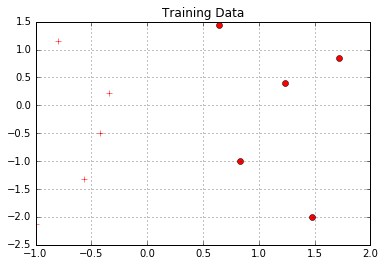

In [7]:
vis_data(x_train, y_train, title = 'Training Data')

## 2. Model Definition

In [8]:
'''
Sigmoid function.

INPUT: A scalar/vector
OUTPUT: A value between (0, 1) for each input component
'''

def sigmoid(a):
    return 1. / (1. + numpy.exp(-a))

In [9]:
'''
Definition of the logistic regression model.

INPUT: Feature vector (x) and weight vector (w)
OUTPUT: The probability of each data point belonging to the positive class.
'''

def logreg(x, w, pre=False):
    x = x.reshape([1, -1]) if len(x.shape) < 2 else x
    
    y = numpy.sum(x * w[None,:-1], axis=1) + w[-1]
    if pre:
        return y    
    return sigmoid(y)

In [10]:
'''
Distance function of the logistic regression model (popularly called likelihood). 

INPUT: True labels (y), feature vector (x) and weight vector (w)
OUTPUT: Log of the likelihood for the given 'w'
'''

def logreg_dist(y, x, w, avg=False):
    y_ = logreg(x, w)
    
    d = -(y * numpy.log(y_ + 1e-12) + (1. - y) * numpy.log(1-y_ + 1e-12))
    
    if not avg:
        return d
    return numpy.mean(d)

In [11]:
'''
THIS IS WHAT WE HAD BEFORE!!

Learning rule for the logistic regression model.

INPUT: True labels (y), feature vector (x) and weight vector (w)
OUTPUT: The direction of update for the weight vector
'''

def logreg_rule_defined_manually(y, x, w):
    y_ = logreg(x, w)
    dw = numpy.zeros(w.shape)
    dw[:-1] = numpy.mean((y_ - y)[:, None] * x, axis=0)
    dw[-1] = numpy.mean(y_ - y)
    return dw

In [12]:
'''
THANKS TO AUTOGRAD, THIS IS WHAT WE HAVE NOW!!

Learning rule for the logistic regression model.

INPUT: True labels (y), feature vector (x) and weight vector (w)
OUTPUT: The direction of update for the weight vector
'''

def cost(w, x, y):
    return logreg_dist(y, x, w, avg=True)

# Computing the gradient
logreg_rule = grad(cost)

In [13]:
def _logreg_dist(w, x, y, avg=False):
    return logreg_dist(y, x, w, avg=avg), logreg_rule(w, x, y)

## 3. Learning Process

In [14]:
w0 = 0.01 * numpy.random.randn(n_dim+1); w0[-1] = 0.
w = numpy.copy(w0)

trained_model = scipy.optimize.minimize(_logreg_dist, w0, (x_train, y_train, True), method='CG', jac=True)

In [15]:
print (trained_model)
w = trained_model.x

     fun: 1.9250443929515547e-05
     jac: array([  9.96689954e-06,   7.20796414e-07,  -2.07933880e-06])
 message: 'Optimization terminated successfully.'
    nfev: 2873
     nit: 199
    njev: 2873
  status: 0
 success: True
       x: array([-17.93030046,  -1.3688853 ,   3.44910794])


## 4. Visualize Final Model

In [17]:
def vis_hyperplane(w, typ='k--'):
    plot.hold('on')

    lim0 = plot.gca().get_xlim()
    lim1 = plot.gca().get_ylim()
    m0, m1 = lim0[0], lim0[1]

    intercept0 = -(w[0] * m0 + w[-1])/w[1]
    intercept1 = -(w[0] * m1 + w[-1])/w[1]
    
    plt1, = plot.plot([m0, m1], [intercept0, intercept1], typ)

    plot.gca().set_xlim(lim0)
    plot.gca().set_ylim(lim1)
    
    plot.hold('off')
    
    return plt1

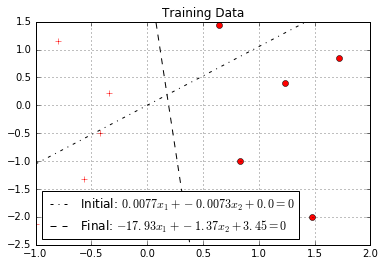

In [18]:
plot.figure()

vis_data(x_train, y_train, c='r', title = 'Training Data')

plt0 = vis_hyperplane(w0, 'k-.')
plt1 = vis_hyperplane(w, 'k--')
plot.legend([plt0, plt1], [
        'Initial: ${:.2} x_1 + {:.2} x_2 + {:.2} = 0$'.format(*list(w0)),
        'Final: ${:.2f} x_1 + {:.2f} x_2 + {:.2f} = 0$'.format(*list(w))],
           loc='best')

plot.show()

In [19]:
def vis_decision_boundary_contour(w, typ='k--'):
    plot.hold('on')
    
    lim0 = plot.gca().get_xlim()
    lim1 = plot.gca().get_ylim()
    
    x_ = numpy.linspace(lim0[0], lim0[1], 100)
    y_ = numpy.linspace(lim1[0], lim1[1], 100)
    xx, yy = numpy.meshgrid(x_, y_)
    
    x_tra_ = numpy.concatenate([xx.ravel()[:,None], yy.ravel()[:,None]], axis=1)
    
    pred = logreg(x_tra_, w)
    plt1 = plot.contourf(xx, yy, pred.reshape(xx.shape), cmap=plot.cm.coolwarm, alpha=0.4)
    
    plot.colorbar(plt1)
    
    plot.gca().set_xlim(lim0)
    plot.gca().set_ylim(lim1)
    
    plot.hold('off')
    
    return plt1

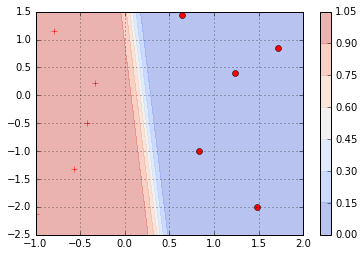

In [20]:
vis_data(x_train, y_train, c='r')

plt1 = vis_decision_boundary_contour(w, 'k--')

## 5. Testing

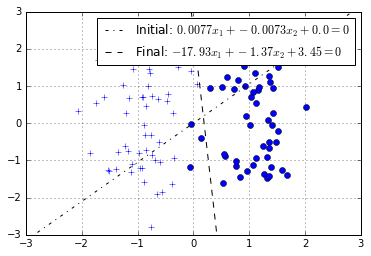

In [21]:
vis_data(x_test, y_test, c='b')

plt0 = vis_hyperplane(w0, 'k-.')
plt1 = vis_hyperplane(w, 'k--')
plot.legend([plt0, plt1], [
        'Initial: ${:.2} x_1 + {:.2} x_2 + {:.2} = 0$'.format(*list(w0)),
        'Final: ${:.2f} x_1 + {:.2f} x_2 + {:.2f} = 0$'.format(*list(w))],
           loc='best')

In [22]:
training_error = numpy.sum(numpy.abs(numpy.round(logreg(x_train, w)) - y_train)) / numpy.float(len(y_train))
test_error = numpy.sum(numpy.abs(numpy.round(logreg(x_test, w)) - y_test)) / numpy.float(len(y_test))

print ('Training error rate {}, Test error rate {}'.format(training_error, test_error))

Training error rate 0.0, Test error rate 0.03
